<a href="https://colab.research.google.com/github/ylkim1947/Project8---Car-brand-classification/blob/main/Car_brand_classification(EfficientNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

In [46]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import time


In [47]:
# Required constants.
BASE_DIR ='/content/drive/MyDrive/cp2/codestates_cp2_cars/096_3_HY'
TRAIN_DIR = f'{BASE_DIR}/1.Training_0/'
VALID_DIR = f'{BASE_DIR}/2.Validation/'
IMAGE_SIZE = 224 # Image size of resize when applying transforms.
BATCH_SIZE = 256
NUM_WORKERS = 8 # Number of parallel processes for data preparation.
# computation device
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")
timestr = time.strftime("%Y%m%d-%H%M%S")

Computation device: cuda



# 01. Dataset 

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# %cd /content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training

# #!unzip -qq "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/검정.zip" -d  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/black"
# #!unzip  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/회색.zip" -d  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/grey" 
# #!unzip  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/빨강.zip" -d  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/red"
# #!unzip  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/흰색.zip" -d  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/white"
# !unzip  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/파랑.zip" -d  "/content/drive/MyDrive/cp2/codestates_cp2_cars/094/1.Training/blue"

In [50]:
# Training transforms
def get_train_transform(IMAGE_SIZE):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(35),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        #transforms.RandomGrayscale(p=0.5),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.RandomPosterize(bits=2, p=0.5),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return train_transform

# Validation transforms
def get_valid_transform(IMAGE_SIZE):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return valid_transform

In [51]:

def get_datasets():
    """
    Function to prepare the Datasets.
    Returns the training and validation datasets along 
    with the class names.
    """
    dataset_train = datasets.ImageFolder(
        TRAIN_DIR, 
        transform=(get_train_transform(IMAGE_SIZE))
    )
    dataset_valid = datasets.ImageFolder(
        VALID_DIR, 
        transform=(get_valid_transform(IMAGE_SIZE))
    )
    return dataset_train, dataset_valid, dataset_train.classes

def get_data_loaders(dataset_train, dataset_valid):
    """
    Prepares the training and validation data loaders.
    :param dataset_train: The training dataset.
    :param dataset_valid: The validation dataset.
    Returns the training and validation data loaders.
    """
    train_loader = DataLoader(
        dataset_train, batch_size=BATCH_SIZE, 
        shuffle=True, num_workers=NUM_WORKERS
    )
    valid_loader = DataLoader(
        dataset_valid, batch_size=BATCH_SIZE, 
        shuffle=False, num_workers=NUM_WORKERS
    )
    return train_loader, valid_loader 

# 02. Model : EfficientNet

In [52]:
import torch.nn as nn
from torchvision import models

def build_model(pretrained=True, fine_tune=True, num_classes=83):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.efficientnet_b0(pretrained=pretrained)
    #model = models.efficientnet_v2_m(pretrained=pretrained)

    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

# 03. Training Setting

In [53]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
#import time

from tqdm.auto import tqdm

#from model import build_model
#from datasets import get_datasets, get_data_loaders

In [54]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [55]:

# Training function.
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc


In [56]:
# Validation function.
def validate(model, testloader, criterion, class_names):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc


# 04. Save model setting

In [57]:
import torch
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')

In [58]:

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"{BASE_DIR}/outputs/model_{timestr}.pth")

def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{BASE_DIR}/outputs/accuracy_{timestr}.png')
    
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{BASE_DIR}/outputs/loss_{timestr}.png')




plt.style.use('ggplot')
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f'{BASE_DIR}/outputs/best_model_{timestr}.pth')

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from torch.utils.tensorboard import SummaryWriter

NANUM_GOTHIC = fm.FontProperties(fname='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
NANUM_GOTHIC_CODING = fm.FontProperties(fname='/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf')

fm.get_fontconfig_fonts()
fm._rebuild


#mpl.rcParams['axes.unicode_minus'] = False

def createConfusionMatrix(loader,model,dataset_classes):
    y_pred = [] # save predction
    y_true = [] # save ground truth

    # iterate over data
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs)  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth

    # constant for classes
    classes = dataset_classes

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index=[i for i in classes],
                         columns=[i for i in classes])
    plt.rc('font', family=NANUM_GOTHIC.get_name() )
    plt.figure(figsize=(12, 7))

    sn.heatmap(df_cm, annot=False).get_figure() 
    plt.savefig(f'{BASE_DIR}/outputs/run/confusionMtx_{timestr}.png')

    return sn.heatmap(df_cm, annot=False).get_figure()

# 05. Run training section

In [60]:
# Load the training and validation datasets.
dataset_train, dataset_valid, dataset_classes = get_datasets()
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
# Load the training and validation data loaders.
train_loader, valid_loader = get_data_loaders(dataset_train, dataset_valid)

[INFO]: Number of training images: 27135
[INFO]: Number of validation images: 3424


In [61]:
dataset_classes

['GE_제네시스015_EQ900_2017',
 'GE_제네시스015_EQ900_2018',
 'GE_제네시스015_EQ900_2019',
 'GE_제네시스018_G70_2017',
 'GE_제네시스018_G70_2018',
 'GE_제네시스018_G70_2019',
 'GE_제네시스018_G70_2020',
 'GE_제네시스018_G70_2021',
 'GE_제네시스019_G80_2017',
 'GE_제네시스019_G80_2018',
 'GE_제네시스019_G80_2019',
 'GE_제네시스019_G80_2020',
 'GE_제네시스019_G80_2021',
 'GE_제네시스020_G90_2019',
 'GE_제네시스020_G90_2020',
 'GE_제네시스020_G90_2021',
 'GE_제네시스024_GV80_2020',
 'GE_제네시스024_GV80_2021',
 'HY_현대025_i30_2017',
 'HY_현대025_i30_2018',
 'HY_현대025_i30_2019',
 'HY_현대041_그랜저_2017',
 'HY_현대041_그랜저_2018',
 'HY_현대041_그랜저_2019',
 'HY_현대041_그랜저_2020',
 'HY_현대041_그랜저_2021',
 'HY_현대042_넥쏘_2020',
 'HY_현대050_맥스크루즈_2017',
 'HY_현대050_맥스크루즈_2018',
 'HY_현대053_베뉴_2019',
 'HY_현대053_베뉴_2020',
 'HY_현대053_베뉴_2021',
 'HY_현대054_벨로스터_2017',
 'HY_현대054_벨로스터_2018',
 'HY_현대054_벨로스터_2019',
 'HY

In [62]:
torch.cuda.is_available()

True

In [63]:
f'{BASE_DIR}/outputs/run/'

'/content/drive/MyDrive/cp2/codestates_cp2_cars/096_3_HY/outputs/run/'

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 5

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...
4,113,871 total parameters.
4,113,871 training parameters.
[INFO]: Epoch 1 of 5
Training


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/106 [00:00<?, ?it/s]

Validation


  0%|          | 0/14 [00:00<?, ?it/s]

Training loss: 2.735, training acc: 25.005
Validation loss: 1.418, validation acc: 44.480

Best validation loss: 1.4179900799478804

Saving best model for epoch: 1



/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s

--------------------------------------------------
[INFO]: Epoch 2 of 5
Training


  0%|          | 0/106 [00:00<?, ?it/s]

Validation


  0%|          | 0/14 [00:00<?, ?it/s]

Training loss: 1.356, training acc: 47.809
Validation loss: 1.081, validation acc: 53.154

Best validation loss: 1.0811920080866133

Saving best model for epoch: 2



/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s

--------------------------------------------------
[INFO]: Epoch 3 of 5
Training


  0%|          | 0/106 [00:00<?, ?it/s]

Validation


  0%|          | 0/14 [00:00<?, ?it/s]

Training loss: 1.055, training acc: 57.435
Validation loss: 0.902, validation acc: 61.069

Best validation loss: 0.9021557399204799

Saving best model for epoch: 3



/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s

--------------------------------------------------
[INFO]: Epoch 4 of 5
Training


  0%|          | 0/106 [00:00<?, ?it/s]

Validation


  0%|          | 0/14 [00:00<?, ?it/s]

Training loss: 0.901, training acc: 63.464
Validation loss: 0.778, validation acc: 66.647

Best validation loss: 0.7776113493101937

Saving best model for epoch: 4



/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s

--------------------------------------------------
[INFO]: Epoch 5 of 5
Training


  0%|          | 0/106 [00:00<?, ?it/s]

Validation


  0%|          | 0/14 [00:00<?, ?it/s]

Training loss: 0.766, training acc: 68.915
Validation loss: 0.698, validation acc: 70.619

Best validation loss: 0.697973872934069

Saving best model for epoch: 5



/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s

--------------------------------------------------
TRAINING COMPLETE


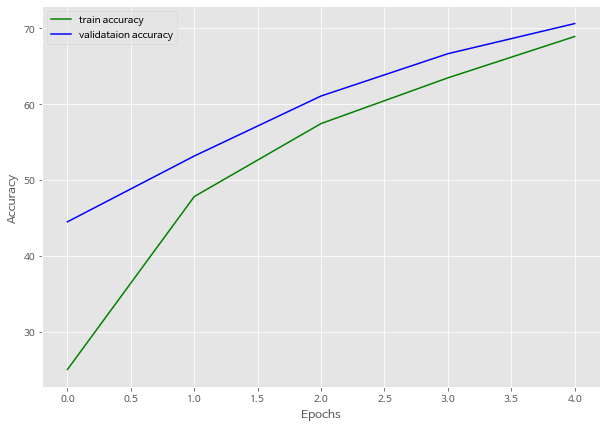

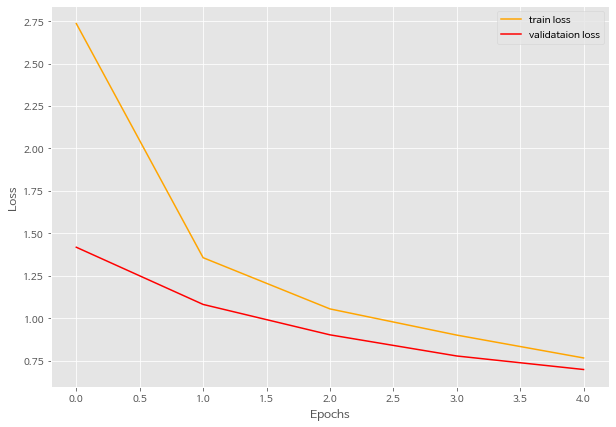

In [66]:
# Learning_parameters. 
lr = 0.001# args['learning_rate']
epochs = 5 #args['epochs']
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")


# Writer will output to ./runs/ directory by default
writer = SummaryWriter(f'{BASE_DIR}/outputs/run/')



# Load the model.
model = build_model(
    pretrained=True,
    fine_tune=True, 
    num_classes=len(dataset_classes)
).to(device)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)
# Loss function.
criterion = nn.CrossEntropyLoss()

# initialize SaveBestModel class
save_best_model = SaveBestModel()

# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                criterion, dataset_classes)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    # save the best model till now if we have the least loss in the current epoch
    save_best_model(
          valid_epoch_loss, epoch, model, optimizer, criterion
          )
    writer.add_scalar("Loss/train", train_epoch_loss, epoch)
    writer.add_scalar("accuracy/train", train_epoch_acc, epoch)
    writer.add_scalar("Loss/valid", valid_epoch_loss, epoch)
    writer.add_scalar("accuracy/valid", valid_epoch_acc, epoch)
    # Save confusion matrix to Tensorboard
    writer.add_figure("Confusion matrix", createConfusionMatrix(train_loader,model,dataset_classes), epoch)



    print('-'*50)
    time.sleep(2)


# Save the trained model weights.
save_model(epochs, model, optimizer, criterion)
# Save the loss and accuracy plots.
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')
# writer.flush()
# writer.close()

In [ ]:
writer.flush()


In [ ]:
writer.close()

In [67]:
!pip install -U tensorboard-plugin-profile


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorboard

In [72]:
!tensorboard --inspect --logdir='/content/drive/MyDrive/cp2/codestates_cp2_cars/096_3_HY/outputs/run/'#f'{BASE_DIR}/outputs/run/'

Processing event files... (this can take a few minutes)

No event files found within logdir /content/drive/MyDrive/cp2/codestates_cp2_cars/096_3_HY/outputs/run/#f/content/drive/MyDrive/cp2/codestates_cp2_cars/096_3_HY/outputs/run/


In [71]:
%load_ext tensorboard
%tensorboard --inspect --logdir f'{BASE_DIR}/outputs/run/'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 0).
Contents of stdout:
Processing event files... (this can take a few minutes)

No event files found within logdir f/content/drive/MyDrive/cp2/codestates_cp2_cars/096_3_HY/outputs/run/

In [ ]:
#import gc
#gc.collect()